In [156]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_ollama import ChatOllama


In [157]:
import json
import os

file_path = os.path.join( "surveys.json")  # Adjust path if needed


In [158]:
llm = ChatOllama(model="llama3.1:latest", temperature=0)


In [159]:
from typing_extensions import TypedDict

class OverallState(TypedDict):
    query:str
    industry:str
    role:str
    channels:str
    name:str
    description:str

In [160]:
from pydantic import BaseModel, Field
from typing import List, Literal

class survey_metadata(BaseModel):
    industry: Literal["saas", "eCommerce", "other"] = Field(..., description="The industry the survey is for.")
    role: Literal["productManager", "marketing", "sales", "customerSuccess", "peopleManager"] = Field(..., description="The role of the person responsible for creating the survey.")
    channels: List[Literal["app", "website", "link"]] = Field(..., description="Where the survey will be distributed (can be multiple channels).")

find_survey_metadata_prompt = """
Analyze the given topic and determine the most relevant survey parameters.
Topic: {topic}

Return a JSON object with:
- "industry": Choose from ["saas", "eCommerce", "other"]
- "role": Choose from ["productManager", "marketing", "sales", "customerSuccess", "peopleManager"]
- "channels": A list of ["app", "website", "link"]
"""


def find_survey_metadata(state:OverallState):
    """find the survey metadata"""
    prompt  = find_survey_metadata_prompt.format(topic=state["query"])
    response = llm.with_structured_output(survey_metadata).invoke(prompt)

    return {"industry":response.industry,"role":response.role,"channels":response.channels, }


In [ ]:
class survey_type(BaseModel):
    name:str
    description:str

survey_type_prompt = """
From the following surveys:  
{surveys}  

Choose the **one** survey that best matches this topic: **"{topic}"**.  
Return only the survey name and a short description.  
"""


def find_survey_type(state: OverallState):
    """Find survey type"""
    with open(file_path, "r") as f:
        surveys = json.load(f)

    industry = state["industry"]
    channels = state["channels"]
    role = state["role"]

    matching_surveys = [
        survey for survey in surveys
        if industry in survey["industry"] and role == survey["role"] and any(c in survey["channels"] for c in channels)
    ]

    print(matching_surveys, "matching_surveys")

    # Handle case where no surveys match
    if not matching_surveys:
        return {"name": None, "description": "No matching survey found."}

    # ✅ Use a separate variable to avoid overwriting
    formatted_prompt = survey_type_prompt.format(topic=state["query"], surveys=matching_surveys)

    response = llm.with_structured_output(survey_type).invoke(formatted_prompt)

    return {"name": response.name, "description": response.description}
    

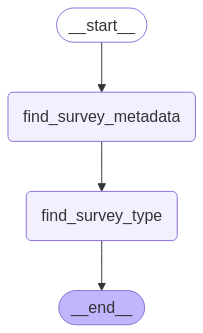

In [162]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph =  StateGraph(OverallState)


graph.add_node("find_survey_metadata", find_survey_metadata)
graph.add_node("find_survey_type", find_survey_type)

graph.add_edge(START, "find_survey_metadata")
graph.add_edge("find_survey_metadata", "find_survey_type")
graph.add_edge("find_survey_type", END)

graph = graph.compile()


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [163]:
result  = graph.invoke({"query":"How can we reduce checkout abandonment ? "})
result

{'query': 'How can we reduce checkout abandonment ? ',
 'industry': 'eCommerce',
 'role': 'productManager',
 'channels': ['app', 'website'],
 'name': 'Rate Checkout Experience',
 'description': 'Let customers rate the checkout experience to tweak conversion.'}